In [221]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

In [237]:
# def grierer_meinhardt(U, V, Du, Dv, c1, c2, c3, c4, c5, k, dt, dx, T, sr=5):
#     n = U.shape[0]
#     iters = int(T / dt)
#     for i in tqdm(range(iters)):
#         Lu = Du*lap_neumann(U)/dx/dx
#         Lv = Dv*lap_neumann(V)/dx/dx
#         uc = U[1:-1, 1:-1]
#         vc = V[1:-1, 1:-1]
#         U[1:-1, 1:-1], V[1:-1, 1:-1] =\
#         uc + dt*(Lu + c1 - c2*uc + c3*uc*uc/(1+k*uc*uc)/vc),\
#         vc + dt*(Lv + c4*uc*uc - c5*vc)
#         for u in (U, V):
#             u[0, :] = u[1, :]
#             u[-1, :] = u[-2, :]
#             u[:, 0] = u[:, 1]
#             u[:, -1] = u[:, -2]
#     return U, V

@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, f, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0):
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.5)*10
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.5)).real*10

    binarized = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels = ndimage.label(binarized, structure=s)
    if labels[1] > 2:
        bins, edges = np.histogram(labels[0], bins=labels[1])
        return bins[1:]

    # Try inversed region
    binarized = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels = ndimage.label(binarized, structure=s)
    if labels[1] > 2:
        bins, edges = np.histogram(labels[0], bins=labels[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

def bulkrun(f, k, n=250, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    u_median, v_median = np.zeros_like(f), np.zeros_like(f)
    u_std, v_std = np.zeros_like(f), np.zeros_like(f)
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, F, k[index], T)
        obj_u = calc_objects(u)
        obj_v = calc_objects(v)
        
        u_median[index] = np.median(obj_u)
        u_std[index] = np.std(obj_u)
        v_median[index] = np.median(obj_v)
        v_std[index] = np.std(obj_v)
    return (u_median, v_median), (u_std, v_std)

def shannon_entropy(inp):
    p = gaussian_kde(inp)
    return quad(lambda x: -p.pdf(x)*p.logpdf(x), -1000, 10000)[0]

def bulk_entropy(f, k, n=150, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, F, k[index], T)
        obj_u = calc_objects(u)
        if obj_u.any():
            outp[index] = shannon_entropy(obj_u)
    return outp

def testyo(f, k, n=150, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    print("F     k")
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        print(f"{F}   {k[index]}   {index}")
    return 0



@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

def convolution(mat, kernel, rep=1):
    for _ in range(rep):
        mat = convolve(mat, kernel, mode='wrap')
    return mat


0.0 mins and 41.46 secs


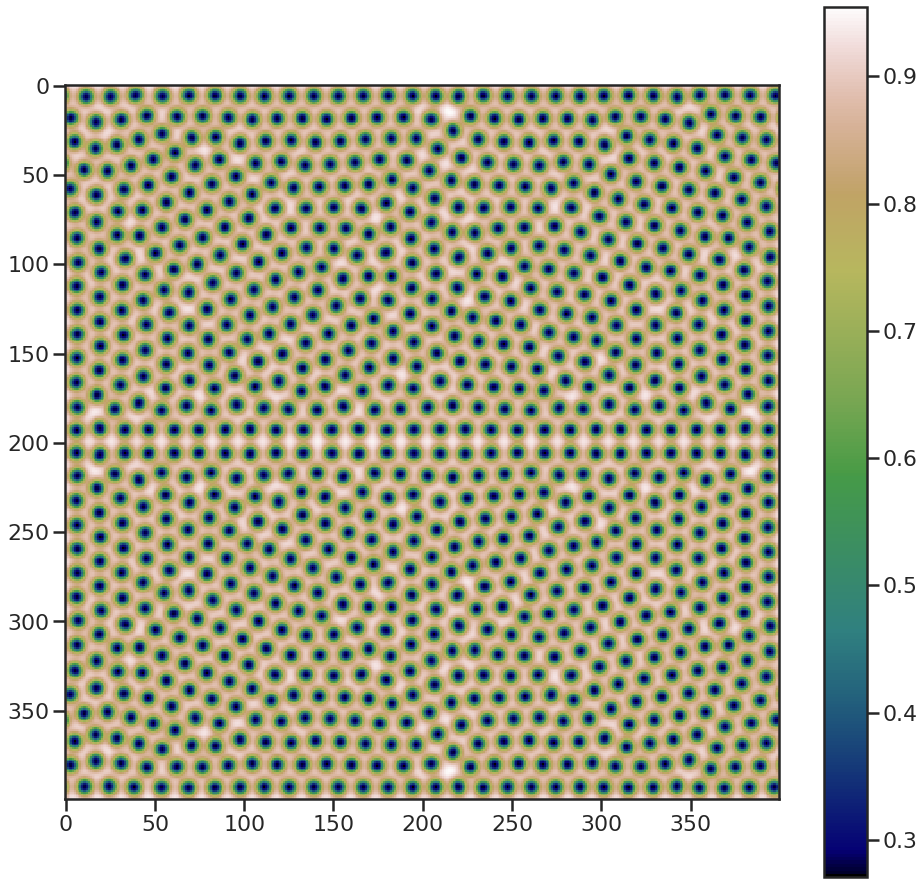

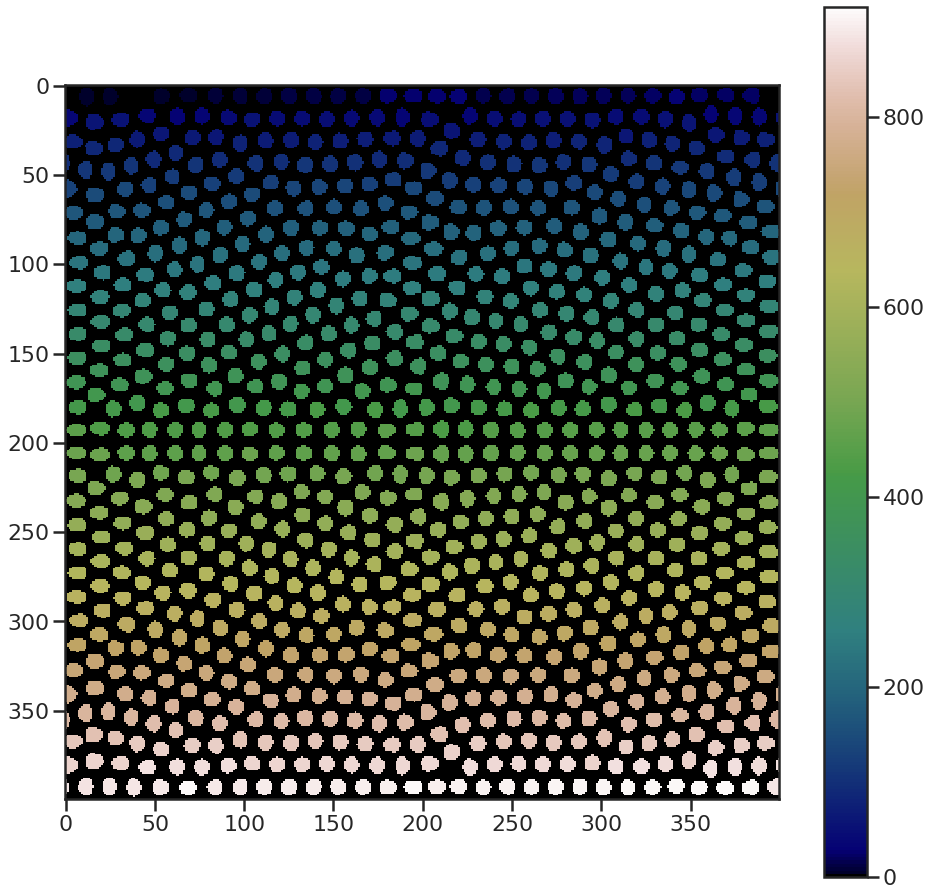

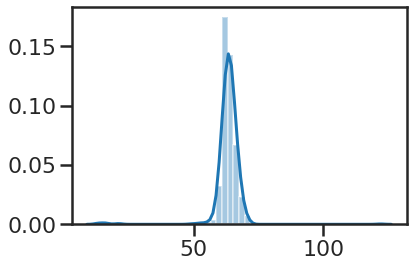

In [3]:
n = 400
Du = 0.16
Dv = 0.08
# F = 0.035
# k = 0.06
F = 0.0335
k = 0.0644
T = 50000
dt = 1.0
dx = 1.0


U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
V[m-r:m+r, m-r:m+r] = 0.5
u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)
labels = ndimage.label(binarized)
bins, edges = np.histogram(labels[0], bins=labels[1])
plt.figure(figsize=(16,16))
plt.imshow(u_out, cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure()
sns.distplot(bins[1:])
plt.show()

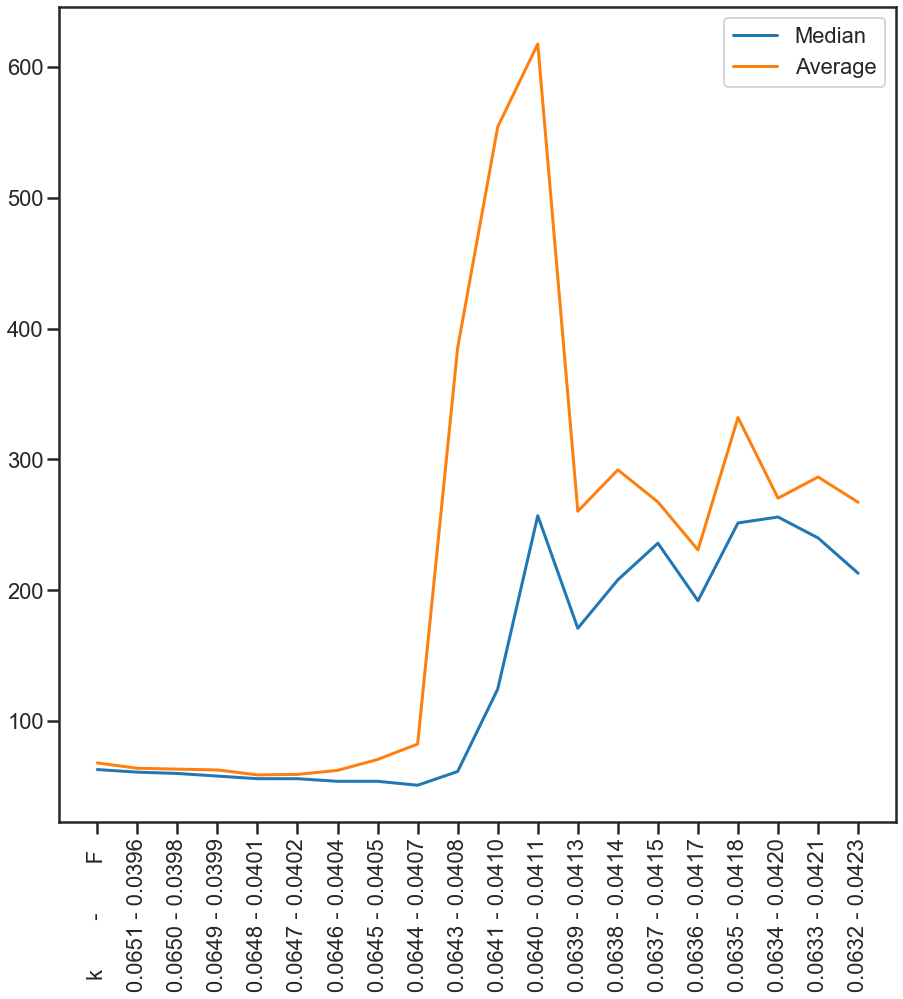

In [16]:
n = 200 #400
Du = 0.16
Dv = 0.08
# F = 0.035
# k = 0.06
F = 0.0335
k = 0.0644
T = 40000
dt = 1.0
dx = 1.0

rangesteps = 3 #20
k_range = np.linspace(0.0652, 0.0632, rangesteps)
F_range = np.linspace(0.0395, 0.04228, rangesteps)

medians = []
means = []
ticklabels = ["{0:.4f} - {1:.4f}".format(k_range[i], F_range[i]) for i in range(rangesteps)]
ticklabels[0] = "k        -        F  "

for i in tqdm(range(rangesteps)):
#     print(f"step {i}/{rangesteps}")
    k = k_range[i]
    F = F_range[i]
#     print(f"k = {k}, f = {F}")
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    V[m-r:m+r, m-r:m+r] = 0.5
    u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

    binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)
    labels = ndimage.label(binarized)
    bins, edges = np.histogram(labels[0], bins=labels[1])
#     plt.figure()
#     sns.distplot(bins[1:])
#     plt.show()
#     print(f"average = {np.mean(bins[1:])}")
#     print(f"median = {np.median(bins[1:])}\n\n")
    medians.append(np.median(bins[1:]))
    means.append(np.mean(bins[1:]))
plt.figure(figsize=(15,15))
plt.plot(medians, label="Median")
plt.plot(means, label="Average")
plt.xticks(range(rangesteps), ticklabels, rotation='vertical')
plt.legend()
plt.show()

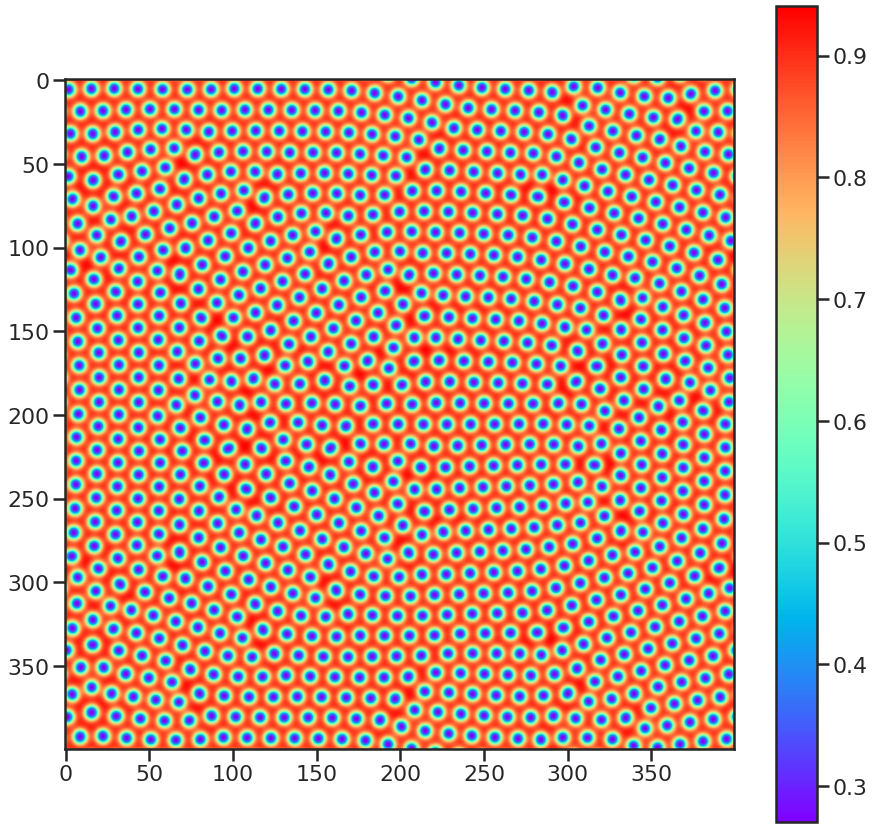

In [115]:
plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='rainbow', interpolation='lanczos')
plt.colorbar()
plt.show()

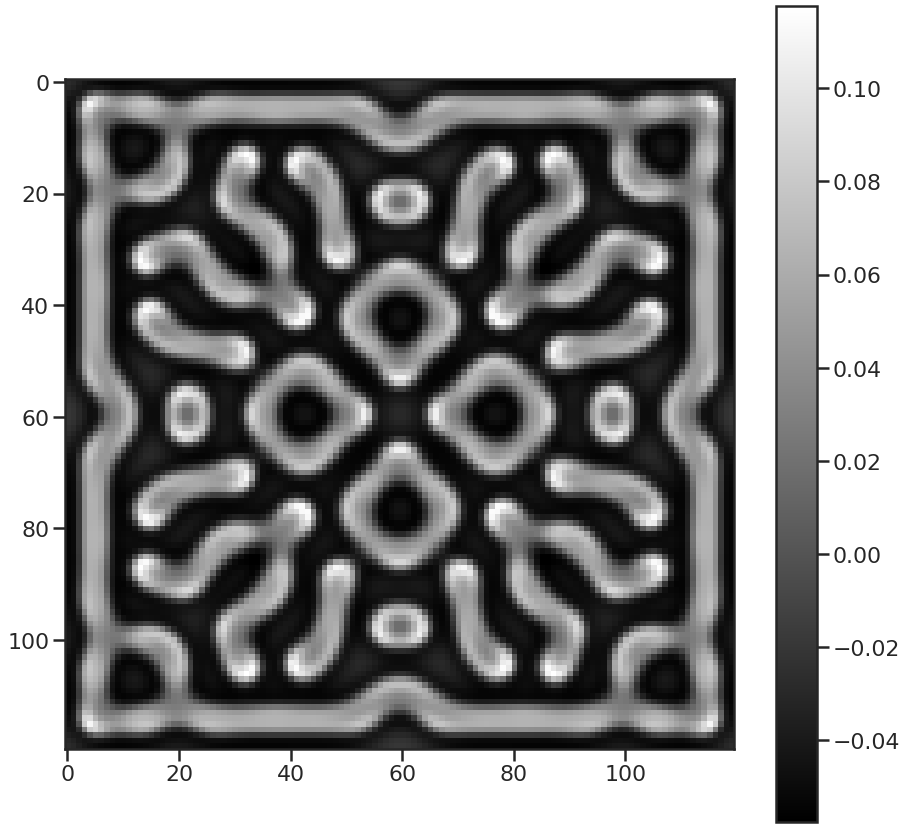

In [39]:
edge1 = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
edge2 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
edge3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
plt.figure(figsize=(15,15))
plt.imshow(convolution(u_out, edge2, 1), cmap='gray')
plt.colorbar()
plt.show()

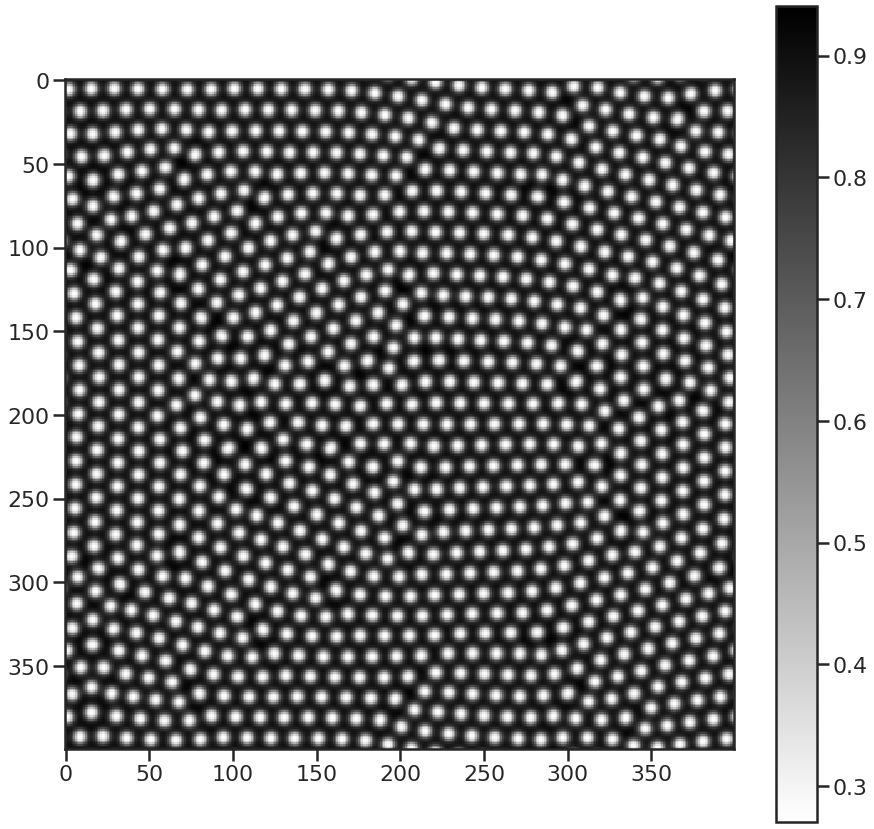

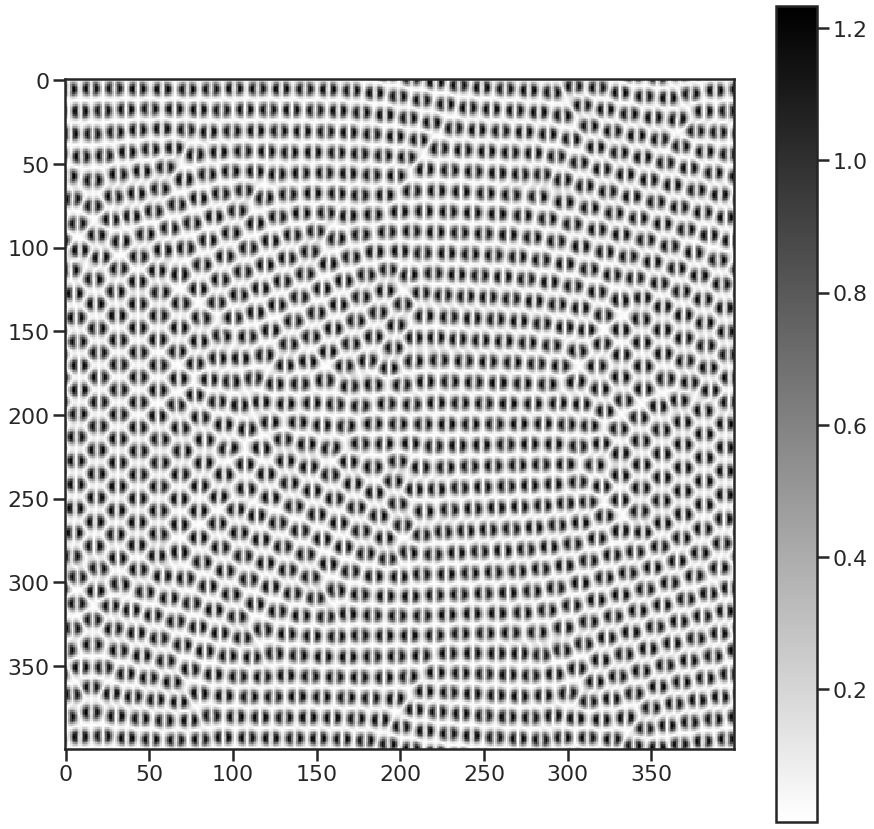

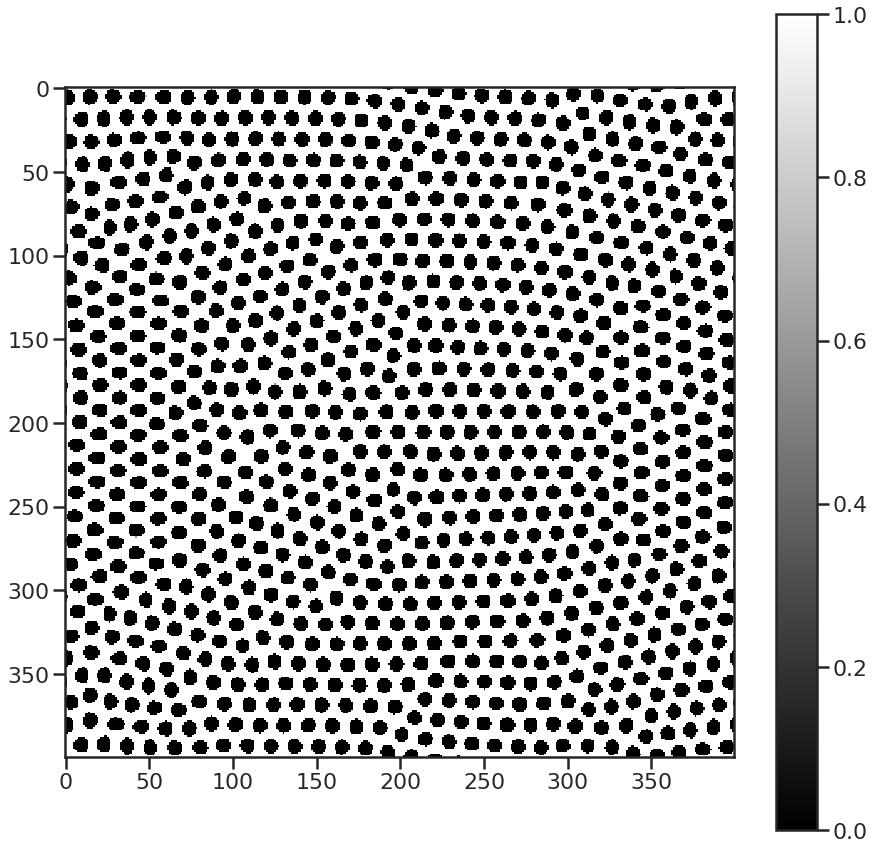

In [116]:
plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='binary')
plt.colorbar()
plt.show()

sobel1 = sobel(u_out, mode='wrap')

plt.figure(figsize=(15,15))
plt.imshow(np.abs(sobel1), cmap='binary')
plt.colorbar()
plt.show()

sobel2 = sobel(sobel(u_out, mode='wrap'))

plt.figure(figsize=(15,15))
plt.imshow(np.clip(preprocessing.scale(u_out)*1000, 0, 1), cmap='gray')
plt.colorbar()
plt.show()

binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)

In [19]:
np.sum(u_out)

8019.079052377486

In [117]:
labels = ndimage.label(binarized)

In [118]:
len(labels[0])

400

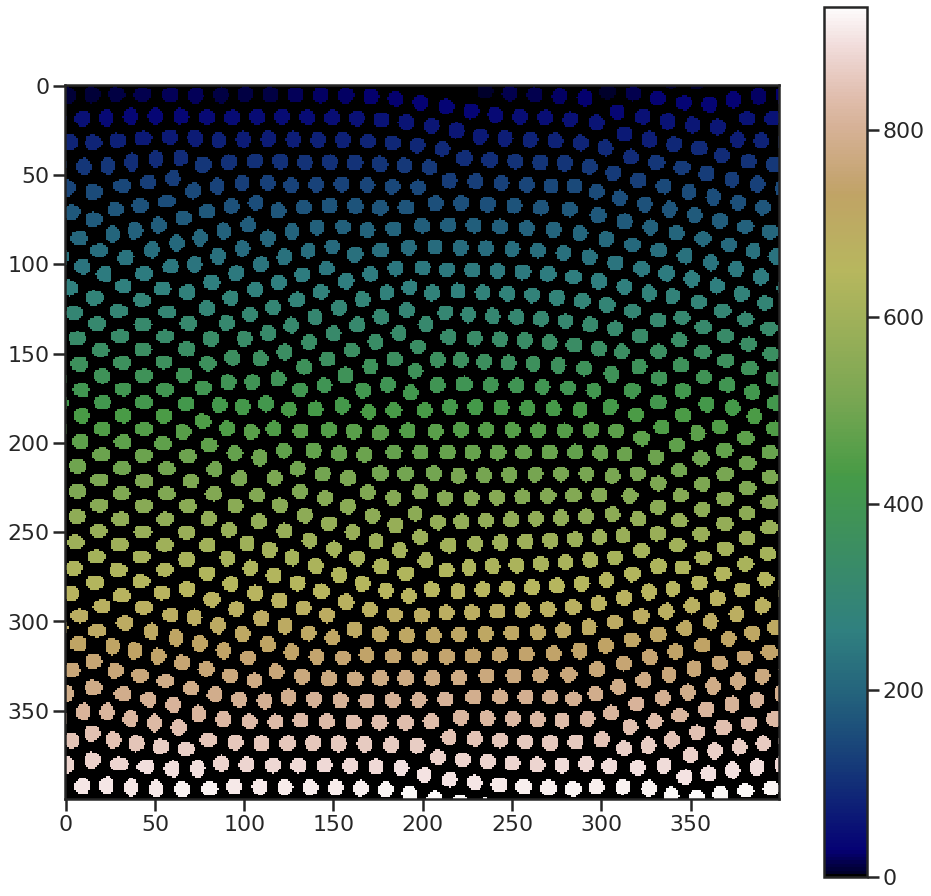

In [127]:
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()

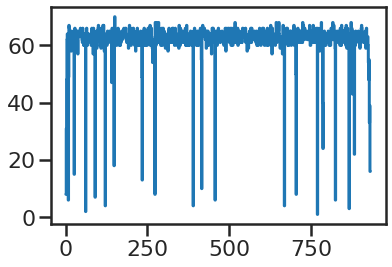

In [120]:
bins, edges = np.histogram(labels[0], bins=labels[1])
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()
plt.plot(X[2:], Y[2:])

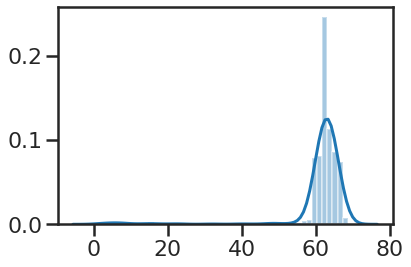

In [121]:
sns.distplot(bins[1:])

In [139]:
len(b)

42

0.0 mins and 11.84 secs


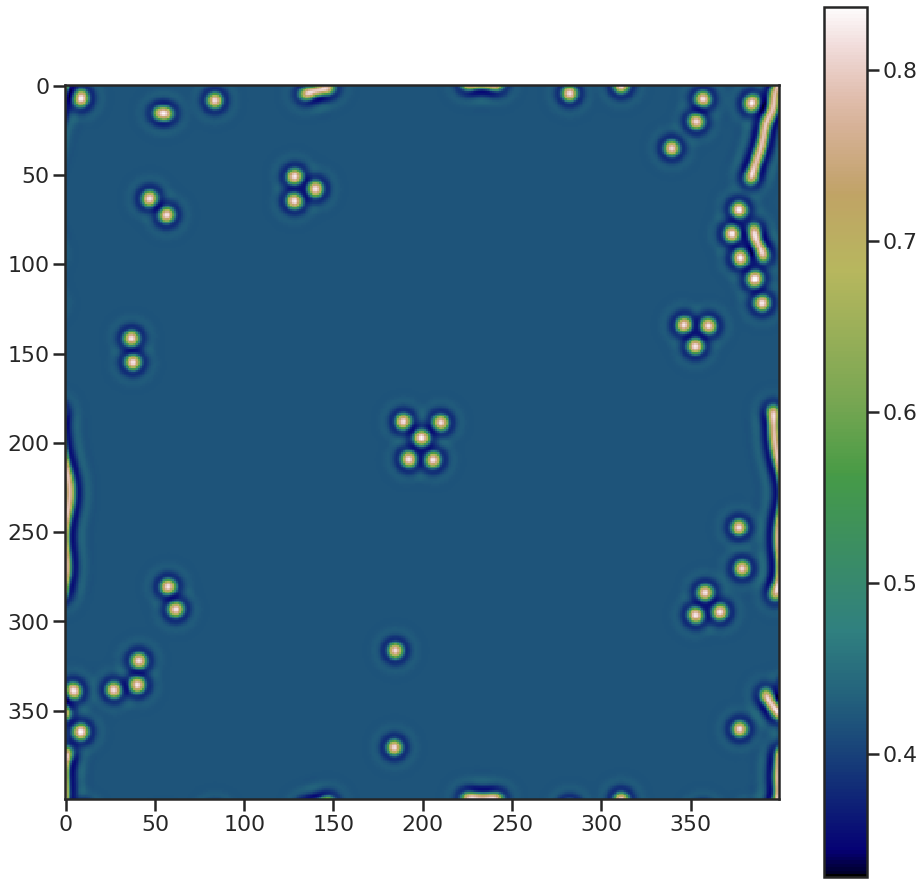

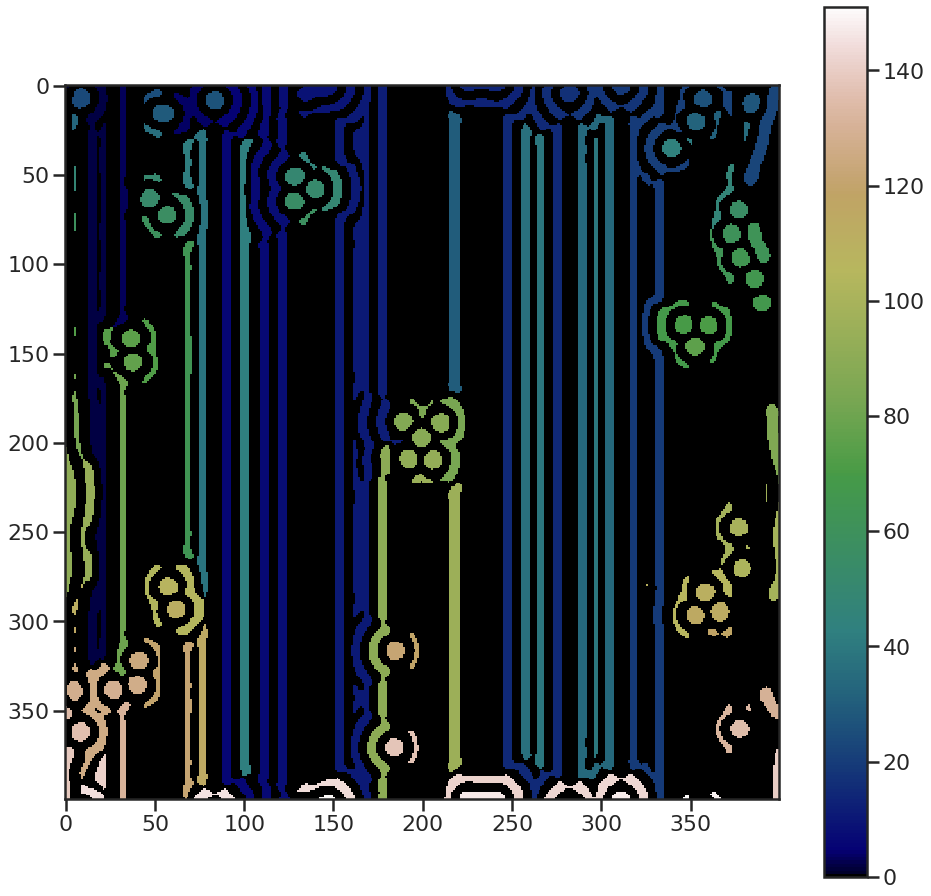

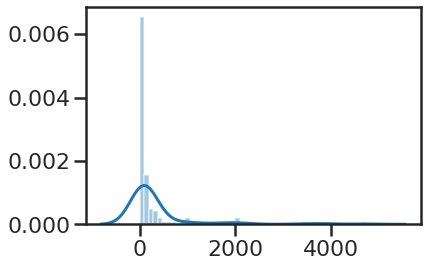

In [35]:
n = 400
Du = 0.16
Dv = 0.08
# F = 0.035
# k = 0.06
F = 0.062
k = 0.0609
T = 30000
dt = 1.0
dx = 1.0


U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
U[m-r:m+r, m-r:m+r] = 0.5
U += np.random.normal(scale=0.05, size=U.shape)
V = np.clip(V + np.random.normal(scale=0.05, size=V.shape), 0, None)
u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

binarized = np.clip(preprocessing.scale(u_out)*1000, 0, 1)
labels = ndimage.label(binarized)
bins, edges = np.histogram(labels[0], bins=labels[1])
plt.figure(figsize=(16,16))
plt.imshow(u_out, cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure()
sns.distplot(bins[1:])
plt.show()

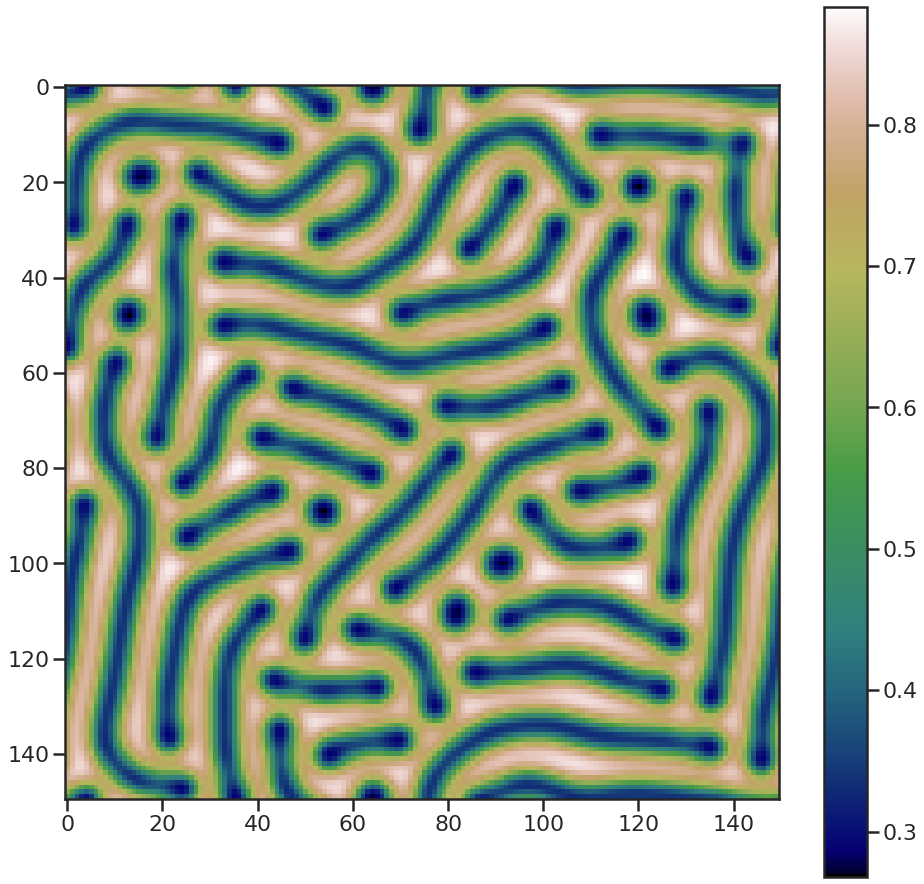

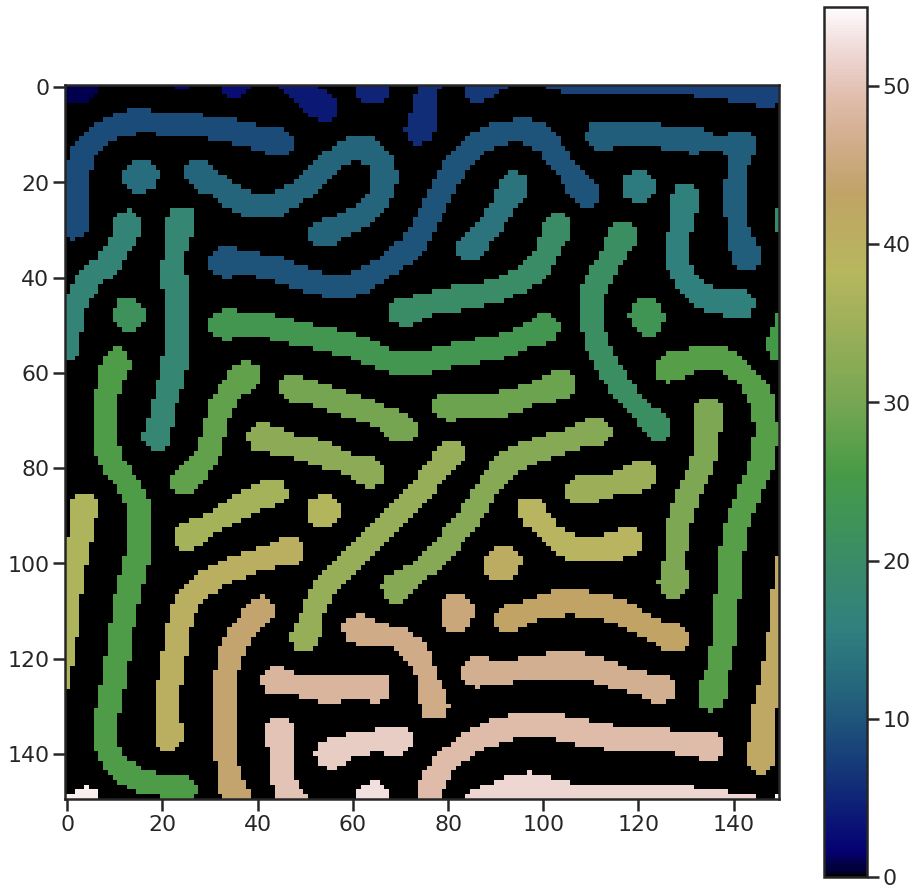

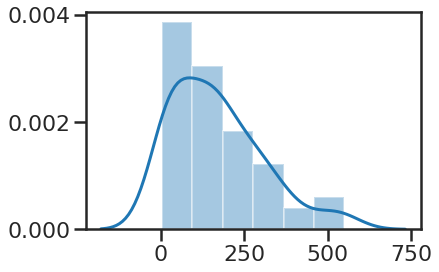

In [139]:
n = 150
Du = 0.16
Dv = 0.08
#F = 0.035
#k = 0.06
F = 0.036
k = 0.062
T = 10000
dt = 1.0
dx = 1.0
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]


U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
U[m-r:m+r, m-r:m+r] = 0.5
U += np.random.normal(scale=0.05, size=U.shape)
V += np.random.normal(scale=0.05, size=V.shape)
u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

fftding = np.fft.fft2(v_out)
outp = ndimage.fourier_ellipsoid(fftding, 1.5)*10
outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.5)).real*10


binarized = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
labels = ndimage.label(binarized, structure=s)
bins, edges = np.histogram(labels[0], bins=labels[1])


plt.figure(figsize=(16,16))
plt.imshow(u_out, cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure()
sns.distplot(bins[1:])
plt.show()

In [142]:
bins

array([13436,    25,     3,    14,    59,    26,    66,    25,   128,
         326,   528,   296,   372,    42,   114,    39,   190,   161,
         268,     5,   236,   263,    38,    45,   387,    20,   550,
         474,   166,   159,   157,   222,   311,   157,   280,   105,
         134,   147,    40,   154,   304,    45,   160,   224,   230,
          47,   160,   242,   141,   355,    93,   109,   187,    21,
          14])

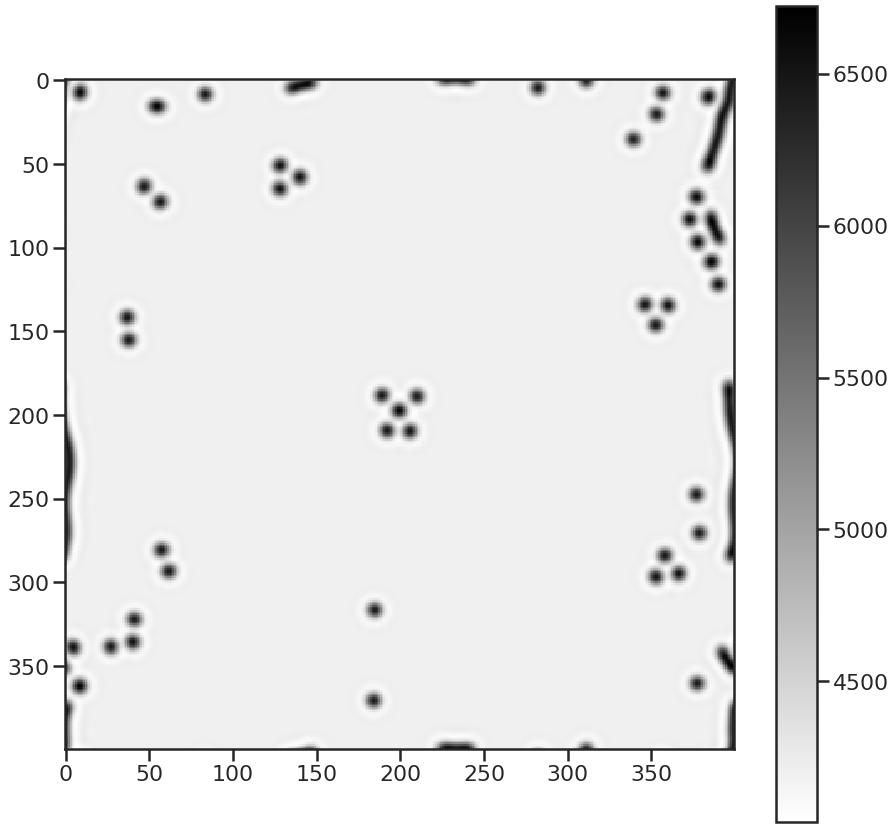

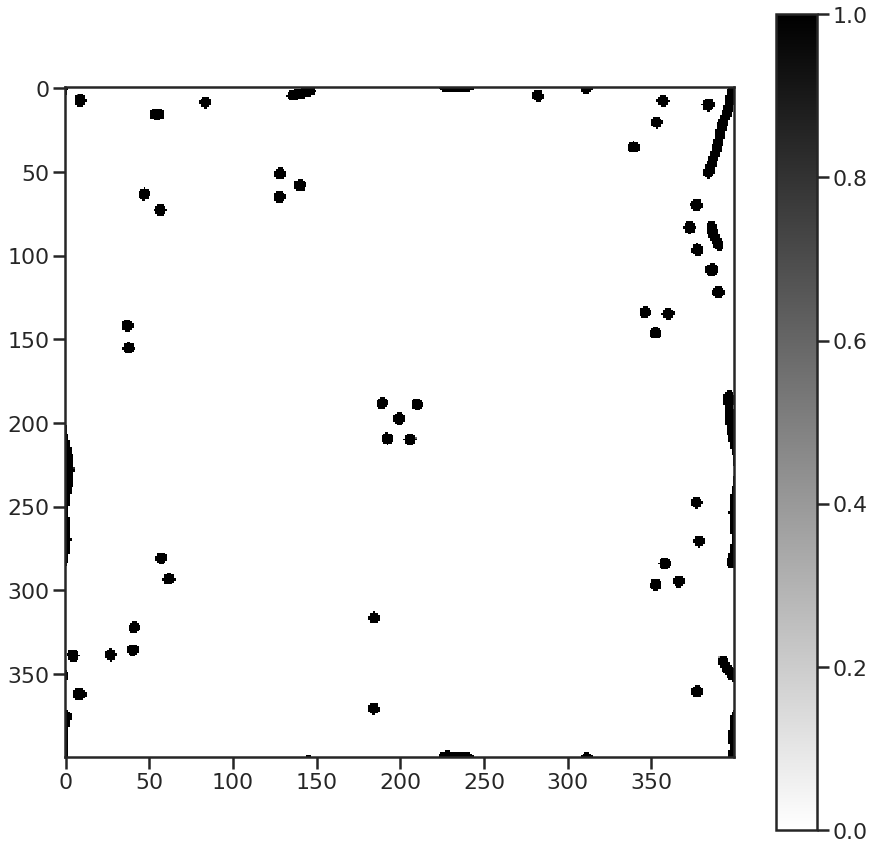

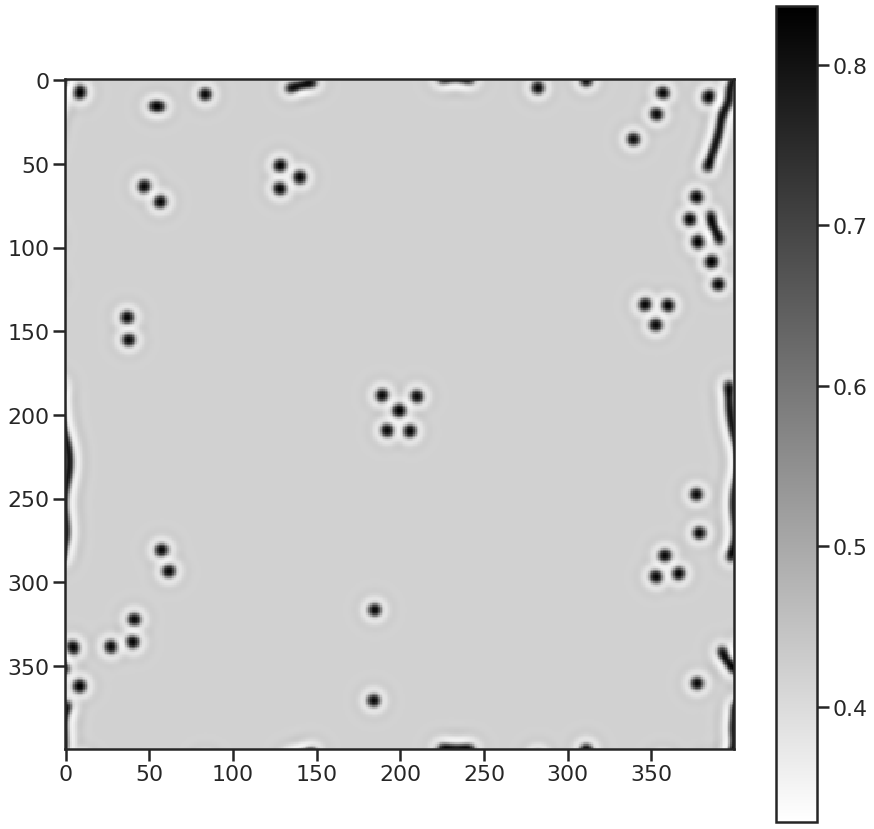

In [97]:
fftding = np.fft.fft2(u_out)
outp = ndimage.fourier_ellipsoid(fftding, 5)*100
outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 2)).real*100


plt.figure(figsize=(15,15))
plt.imshow(outp, cmap='binary')
plt.colorbar()
plt.show()


plt.figure(figsize=(15,15))
plt.imshow(np.clip(outp-((outp.min() + outp.max())/2), 0, 1), cmap='binary')
plt.colorbar()
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='binary')
plt.colorbar()
plt.show()

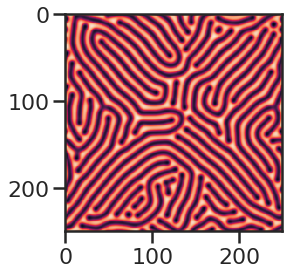

In [213]:
plt.imshow(gscott(250, 0.035, 0.061, 25000)[0])

In [123]:
def funcding(a, b):
    return a + b

In [124]:
ding = np.vectorize(funcding)

In [133]:
a = np.arange(10)

In [135]:
funcding(a, 2)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [136]:
np.zeros((4,4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

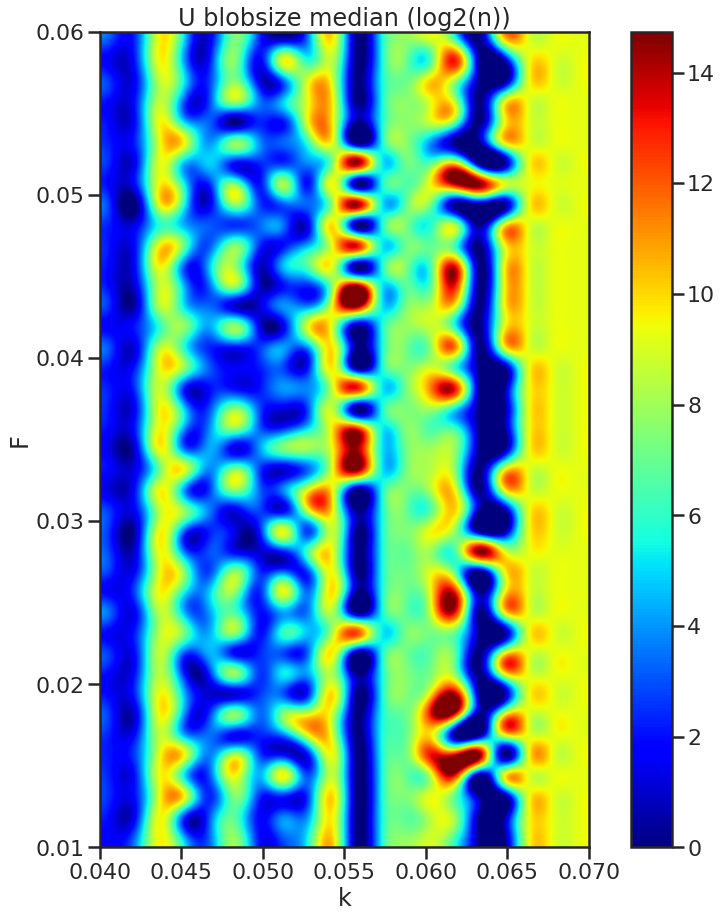

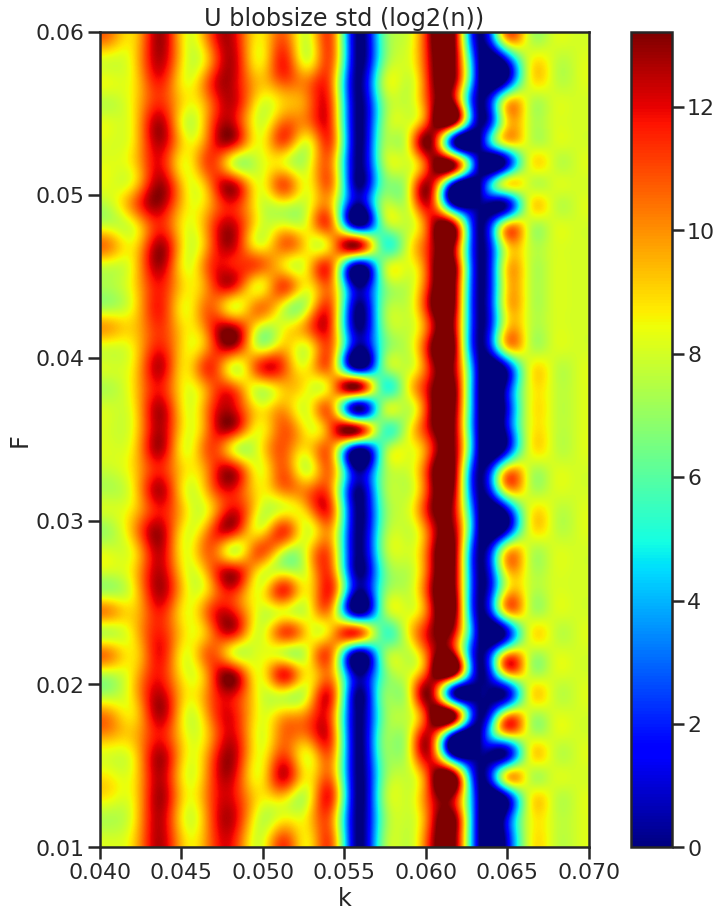

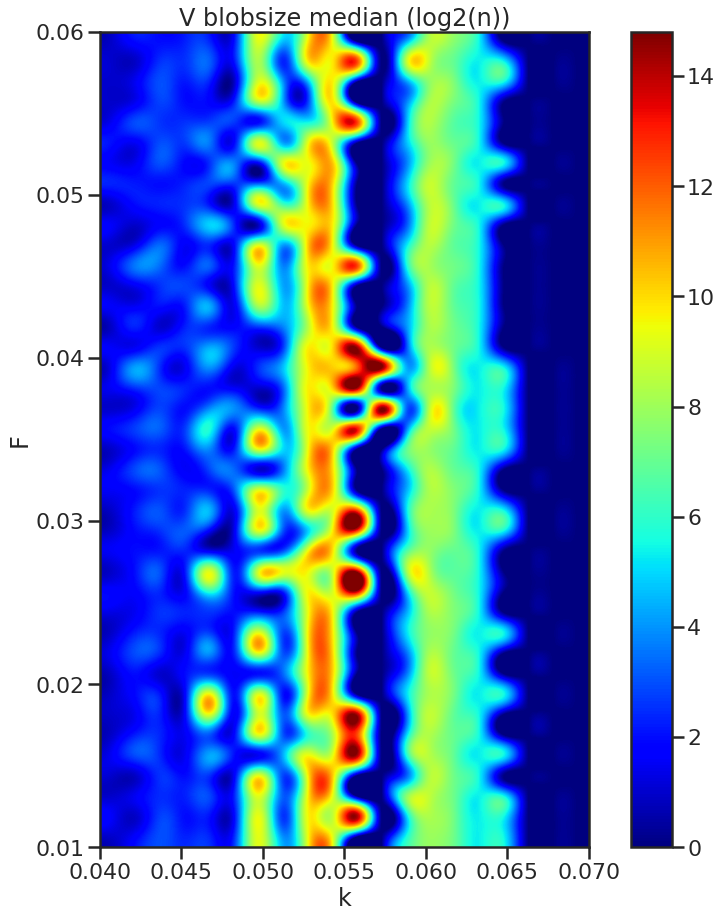

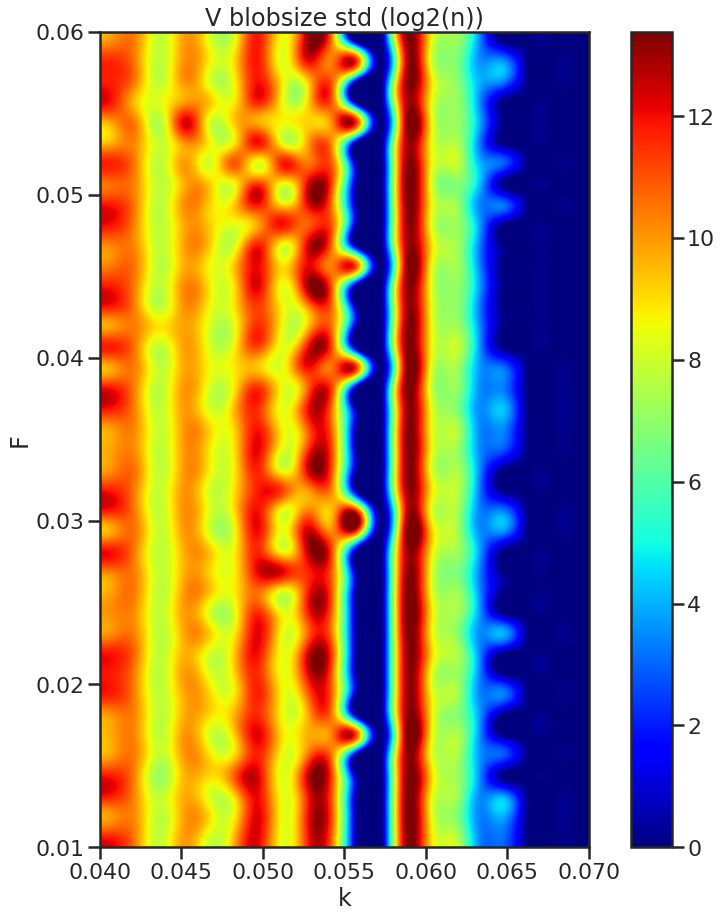

In [219]:
f = np.linspace(0.01, 0.06, 40)
k = np.linspace(0.04, 0.07, 20)

outp = bulkrun(f, k)
meds, stds = outp

log_b = lambda inp, b: xlogy(np.sign(inp), inp)/np.log(b)

plt.figure(figsize=(15,15))
plt.imshow(log_b(meds[0], 2).T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("U blobsize median (log2(n))")
plt.colorbar()
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(log_b(stds[0], 2).T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("U blobsize std (log2(n))")
plt.colorbar()
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(log_b(meds[1], 2).T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("V blobsize median (log2(n))")
plt.colorbar()
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(log_b(stds[1], 2).T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("V blobsize std (log2(n))")
plt.colorbar()
plt.show()


In [165]:
meds, stds = outp

In [172]:
f, k = np.meshgrid(f, k)

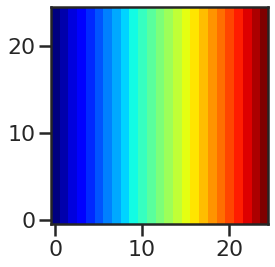

In [185]:
plt.imshow(f, cmap='jet', origin='lower')

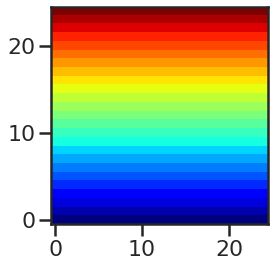

In [186]:
plt.imshow(k, cmap='jet', origin='lower')

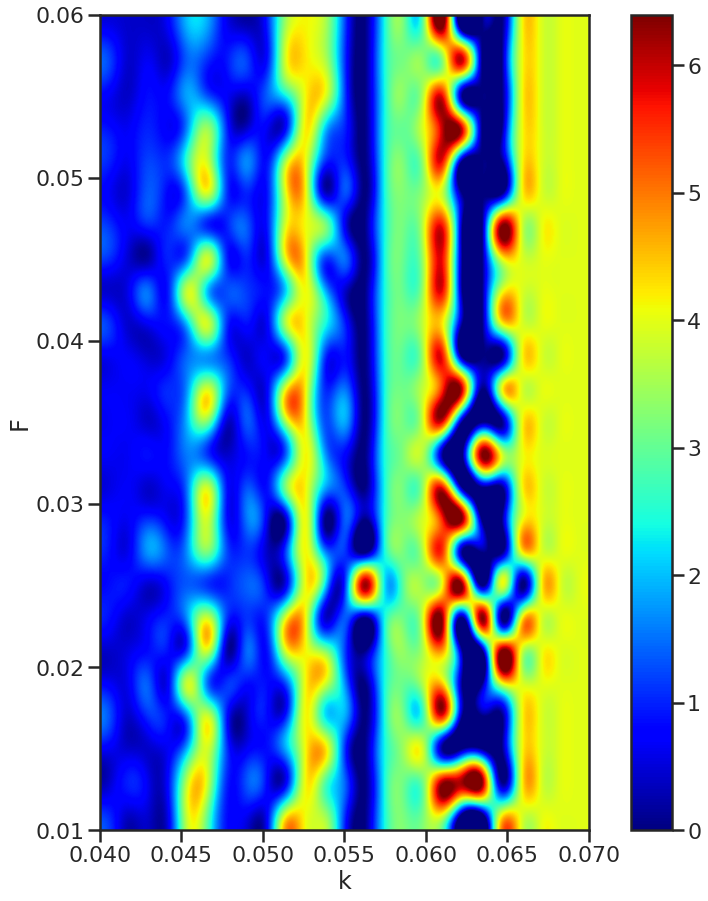

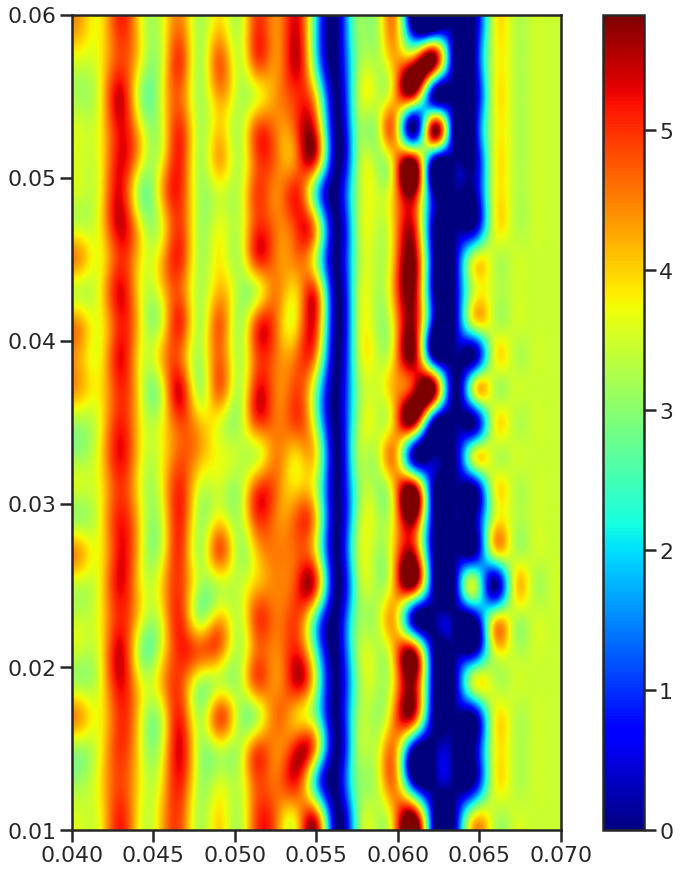

In [218]:
log_b = lambda inp, b: xlogy(np.sign(inp), inp)/np.log(b)

plt.figure(figsize=(15,15))
plt.imshow(log_b(meds[0], 5).T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.colorbar()
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(log_b(stds[0], 5).T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.colorbar()
plt.show()

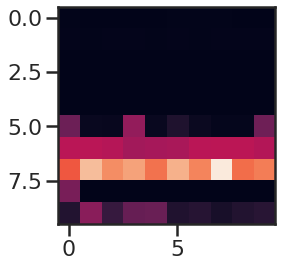

In [149]:
plt.imshow(meds[1])

In [168]:
ndimage.label(np.zeros((10, 10)), structure=s)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32), 0)

In [208]:
log10

NameError: name 'log10' is not defined

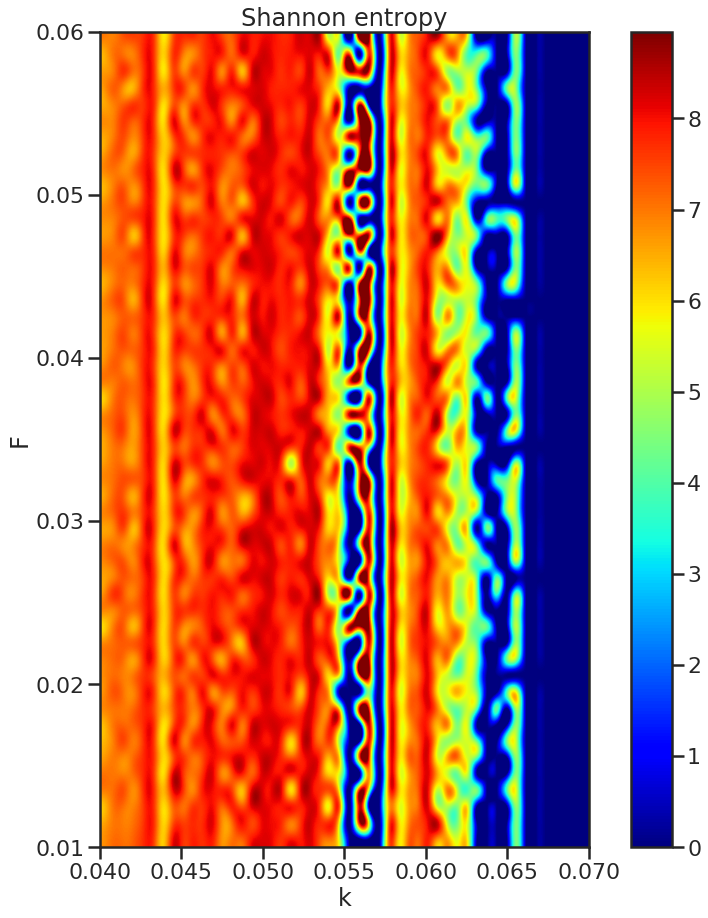

In [246]:
f = np.linspace(0.01, 0.06, 50)
k = np.linspace(0.04, 0.07, 50)

outp = bulk_entropy(f, k)

plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', origin='lower', interpolation='lanczos', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()

In [242]:
testyo(f, k)

F     k


0.01   0.04   (0, 0)
0.015555555555555555   0.04   (0, 1)
0.02111111111111111   0.04   (0, 2)
0.026666666666666665   0.04   (0, 3)
0.03222222222222222   0.04   (0, 4)
0.03777777777777778   0.04   (0, 5)
0.04333333333333333   0.04   (0, 6)
0.048888888888888885   0.04   (0, 7)
0.05444444444444444   0.04   (0, 8)
0.06   0.04   (0, 9)
0.01   0.0475   (1, 0)
0.015555555555555555   0.0475   (1, 1)
0.02111111111111111   0.0475   (1, 2)
0.026666666666666665   0.0475   (1, 3)
0.03222222222222222   0.0475   (1, 4)
0.03777777777777778   0.0475   (1, 5)
0.04333333333333333   0.0475   (1, 6)
0.048888888888888885   0.0475   (1, 7)
0.05444444444444444   0.0475   (1, 8)
0.06   0.0475   (1, 9)
0.01   0.05500000000000001   (2, 0)
0.015555555555555555   0.05500000000000001   (2, 1)
0.02111111111111111   0.05500000000000001   (2, 2)
0.026666666666666665   0.05500000000000001   (2, 3)
0.03222222222222222   0.05500000000000001   (2, 4)
0.03777777777777778   0.05500000000000001   (2, 5)
0.04333333333333333  

0

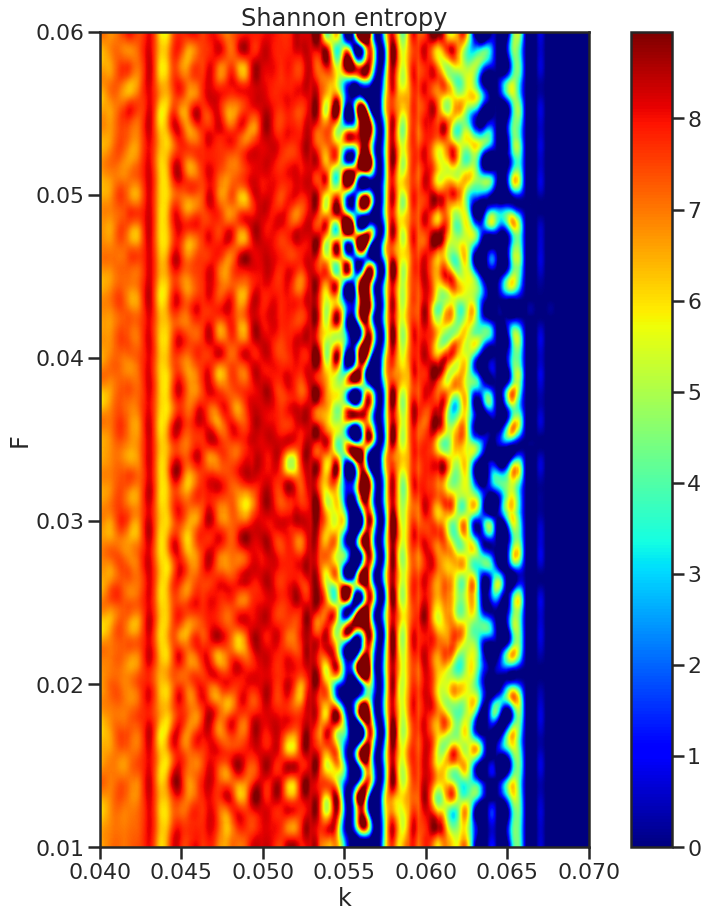

In [252]:
plt.figure(figsize=(15,15))
plt.imshow(outp.T, cmap='jet', origin='lower', interpolation='sinc', extent=(0.04, 0.07, 0.01, 0.06))
plt.xlabel("k")
plt.ylabel("F")
plt.title("Shannon entropy")
plt.colorbar()
plt.show()